<a href="https://colab.research.google.com/github/hinblue0/imsi/blob/main/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

#dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import os

#display images
from torchvision import utils
import matplotlib.pyplot as plt

#utils
import numpy as np
from torchsummary import summary
import time
import copy

In [ ]:
#specify path to data
path2data = '/pracdata'
if not os.path.exists(path2data):
  os.mkdir(path2data)

train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))


Extracting /pracdata/stl10_binary.tar.gz to /pracdata
Files already downloaded and verified
5000
8000


In [ ]:
#define transformation
transformation = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(224)
])

#apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

#make dataload
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

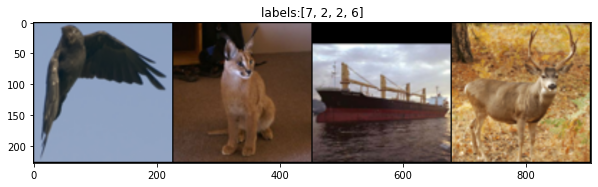

In [ ]:
def show(img, y=None):
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title('labels:' +str(y))

np.random.seed(10)
torch.manual_seed(10)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow = grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

#y_grid에 val이 아닌 train_ds[i][1]해야 되는거 아닌가?

In [ ]:
class Swish(nn.Module):
  def __init__(self):
    super().__init__()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return x*self.sigmoid(x)

if __name__ == '__main__':
  x = torch.randn(3,3,224,224)
  model = Swish()
  output = model(x)
  print('output size', output.size())


IndexError: ignored

In [ ]:
#SE Block
class SEBlock(nn.Module):
  def __init__(self, in_channels, r=4):
    super().__init__()

    self.squeeze = nn.AdaptiveAvgPool2d((1,1))
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, in_channels//r),
        Swish(),
        nn.Linear(in_channels//r, in_channels),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.squeeze(x)
    x = x.view(x.size(0), -1)
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1, 1)
    return x
  
#check
if __name__ == '__main__':
  x = torch.randn(3, 56, 17, 17)
  model = SEBlock(x.size(1))
  output = model(x)
  print('output size:', output.size())


In [ ]:
class MBConv(nn.Module):
  expand = 6
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first MBConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()
    self.residual = nn.Sequential(
        nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
        nn.BatchNorm2d(in_channels*MBConv.expand, momentum=0.99, eps=1e-3),
        Swish(),
        nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                  stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
        nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )

    self.se = SEBlock(in_channels * MBConv.expand, se_scale)

    self.project = nn.Sequential(
        nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
    )
    
    self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
      #stochastic depth
      if self.training:
        if not torch.bernoulli(self.p):
          return x

      x_shortcut = x
      x_residual = self.residual(x)
      x_se = self.se(x_residual)

      x =x_se * x_residual
      x = self.project(x)

      if self.shortcut:
        x = x_shortcut + x
      
      return x

#check
if __name__ '__main__':
  x = torch.rnadn(3, 16, 24, 24)
  model = MBConv(x.size(1), x.size(1), 3, stride=1, p=1)
  model.train()
  output = model(x)
  x = (output == x)
  print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

In [ ]:
class SepConv(nn.Module):
  expand = 1
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first SepConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

    self.residual = nn.Sequential(
        nn.Conv2d(in_channels * SepConv.expand, in_channels *SepConv.expand, kernel_size=kernel_size, stride=1,
                  padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
        nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )

    self.se = SEBlock(in_channels * SepConv.expand, se_scale)

    self.project = nn.Sequential(
        nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    
    x_shortout = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x = x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x

    return x

#check
if __name__ == '__main__':
  x = torch.randn(3, 16, 24, 24)
  model = SepConv(x.size(1), x.size(1), 3, stride=1, p=1)
  model.train()
  output = model(x)
  #stochastic depth check
  x = (output == x)
  print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

NameError: ignored

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
    super().__init__()
    channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
    repeats = [1, 2, 2, 3, 3, 4, 1]
    strides = [1, 2, 2, 2, 1, 2, 1]
    kernel_size = [3, 3, 5, 3, 5, 5, 3]
    depth = depth_coef
    width = width_coef

    channels = [int(x*width) for x in channels]
    repeats = [int(x*depth) for x in repeats]

    #stochastic depth
    if stochastic_depth:
      self.p = p
      self.step = (1-0.5)/(sum(repeats)-1)
    else:
      self.p = 1
      self.step = 0
    
    #efficient net
    self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

    self.stage1 = nn.Sequential(
        nn.Conv2d(3, channels[0], 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
    )
    self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)
    self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)
    self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)
    self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)
    self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)
    self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)
    self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)
    self.stage9 = nn.Sequential(
        nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
        nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
        Swish()
    )
    
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout(p=dropout)
    self.linear = nn.Linear(channels[8], num_classes)

  def forward(self, x):
    x = self.upsample(x)
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    x = self.stage6(x)
    x = self.stage7(x)
    x = self.stage8(x)
    x = self.stage9(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.linear(x)
    return x

  def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
    strides = [stride] + [1] * (repeats - 1)
    layers = []
    for stride in strides:
      layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
      in_channels = out_channels
      self.p -= self.step

    return nn.Sequential(*layers)


def efficientnet_b0(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)

# check
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.randn(3, 3, 224, 224).to(device)
    model = efficientnet_b0().to(device)
    output = model(x)
    print('output size:', output.size())

TypeError: ignored

Files already downloaded and verified
Files already downloaded and verified
5000
8000
output size torch.Size([3, 3, 224, 224])
output size: torch.Size([3, 56, 1, 1])
Epoch 0/99, current lr= 0.01
Copied best model weights!
train loss: 2.114378, val loss: 1.969333, accuracy: 20.16, time: 0.8712 min
----------
Epoch 1/99, current lr= 0.01
Copied best model weights!
train loss: 1.839259, val loss: 1.829577, accuracy: 24.46, time: 1.7412 min
----------
Epoch 2/99, current lr= 0.01
Copied best model weights!
train loss: 1.758453, val loss: 1.764113, accuracy: 30.26, time: 2.6136 min
----------
Epoch 3/99, current lr= 0.01
Copied best model weights!
train loss: 1.697582, val loss: 1.743804, accuracy: 29.65, time: 3.4895 min
----------
Epoch 4/99, current lr= 0.01
train loss: 1.661741, val loss: 1.747358, accuracy: 30.50, time: 4.3643 min
----------
Epoch 5/99, current lr= 0.01
train loss: 1.583802, val loss: 2.903603, accuracy: 27.26, time: 5.2396 min
----------
Epoch 6/99, current lr= 0.01
t

KeyboardInterrupt: ignored

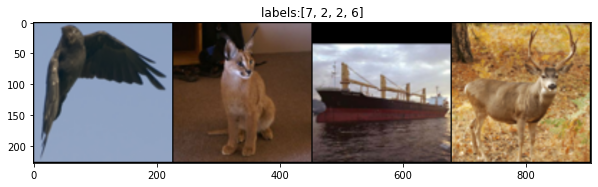

In [ ]:
##########################1d로 변경중
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

#dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import os

#display images
from torchvision import utils
import matplotlib.pyplot as plt

#utils
import numpy as np
from torchsummary import summary
import time
import copy

#specify path to data
path2data = '/pracdata'
if not os.path.exists(path2data):
  os.mkdir(path2data)

train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

#define transformation
transformation = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(224)
])

#apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

#make dataload
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

def show(img, y=None):
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title('labels:' +str(y))

np.random.seed(10)
torch.manual_seed(10)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow = grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

#y_grid에 val이 아닌 train_ds[i][1]해야 되는거 아닌가?

class Swish(nn.Module):
  def __init__(self):
    super().__init__()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return x*self.sigmoid(x)

if __name__ == '__main__':
  x = torch.randn(3,3,224,224)
  model = Swish()
  output = model(x)
  print('output size', output.size())


#SE Block
class SEBlock(nn.Module):
  def __init__(self, in_channels, r=4):
    super().__init__()

    self.squeeze = nn.AdaptiveAvgPool1d(1)
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, in_channels//r),
        Swish(),
        nn.Linear(in_channels//r, in_channels),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.squeeze(x)
    x = x.view(x.size(0), -1)
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1)
    return x
  
#check
if __name__ == '__main__':
  x = torch.randn(3, 56, 17, 17)
  model = SEBlock(x.size(1))
  output = model(x)
  print('output size:', output.size())


class MBConv(nn.Module):
  expand = 6
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first MBConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()
    self.residual = nn.Sequential(
        nn.Conv1d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
        nn.BatchNorm1d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish(),
        nn.Conv1d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                  stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
        nn.BatchNorm1d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )
    self.se = SEBlock(in_channels * MBConv.expand, se_scale)
    self.project = nn.Sequential(
        nn.Conv1d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    x_shortcut = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x =x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x
    
    return x


class SepConv(nn.Module):
  expand = 1
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first SepConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

    self.residual = nn.Sequential(
        nn.Conv1d(in_channels * SepConv.expand, in_channels *SepConv.expand, kernel_size=kernel_size, stride=1,
                  padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
        nn.BatchNorm1d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )

    self.se = SEBlock(in_channels * SepConv.expand, se_scale)

    self.project = nn.Sequential(
        nn.Conv1d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    
    x_shortcut = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x = x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x

    return x


class EfficientNet(nn.Module):
  def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
    super().__init__()
    channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
    repeats = [1, 2, 2, 3, 3, 4, 1]
    strides = [1, 2, 2, 2, 1, 2, 1]
    kernel_size = [3, 3, 5, 3, 5, 5, 3]
    depth = depth_coef
    width = width_coef

    channels = [int(x*width) for x in channels]
    repeats = [int(x*depth) for x in repeats]

    #stochastic depth
    if stochastic_depth:
      self.p = p
      self.step = (1-0.5)/(sum(repeats)-1)
    else:
      self.p = 1
      self.step = 0
    
    #efficient net
    self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

    self.stage1 = nn.Sequential(
        nn.Conv1d(3, channels[0], 3, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(channels[0], momentum=0.99, eps=1e-3)
    )
    self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)
    self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)
    self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)
    self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)
    self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)
    self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)
    self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)
    self.stage9 = nn.Sequential(
        nn.Conv1d(channels[7], channels[8], 1, stride=1, bias=False),
        nn.BatchNorm1d(channels[8], momentum=0.99, eps=1e-3),
        Swish()
    )
    
    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(p=dropout)
    self.linear = nn.Linear(channels[8], num_classes)

  def forward(self, x):
    x = self.upsample(x)
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    x = self.stage6(x)
    x = self.stage7(x)
    x = self.stage8(x)
    x = self.stage9(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.linear(x)
    return x

  def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
    strides = [stride] + [1] * (repeats - 1)
    layers = []
    for stride in strides:
      layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
      in_channels = out_channels
      self.p -= self.step

    return nn.Sequential(*layers)


def efficientnet_b0(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0().to(device)
#summary(model, (3,224,224), device=device.type)

# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history


params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

model, loss_hist, metric_hist = train_val(model, params_train)


224


Files already downloaded and verified
batch_size : 128,  tvt : 32 / 4 / 4


Epoch 0/299
----------
train Loss: 0.08 Acc: 97.7
valid Loss: 2.41 Acc: 49.6
==> best model saved - 0 / 49.6
Epoch 1/299
----------
train Loss: 0.07 Acc: 97.7
valid Loss: 2.52 Acc: 54.0
==> best model saved - 1 / 54.0
Epoch 2/299
----------
train Loss: 0.08 Acc: 97.1
valid Loss: 2.28 Acc: 55.2
==> best model saved - 2 / 55.2
Epoch 3/299
----------
train Loss: 0.09 Acc: 96.9
valid Loss: 2.34 Acc: 53.4
Epoch 4/299
----------


KeyboardInterrupt: ignored

Cloning into 'efficientnet-pytorch'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (52/52), done.

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


/


In [ ]:
#batch128 늘리면 학습안되. upsample(resorlution 늘리는) 사용해도 1d라 오류
# -2, -2~2, 2의 비율을 균등하게..(-2~2가 휠씬 많으므로)
#CNN
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import argparse
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect('drive/MyDrive/Colab Notebooks/StockWeek.db')
#con = sqlite3.connect('E:\(prac)python/StockWeek.db')
df = pd.read_sql('select * from A000020', con, index_col='Date')
df = df.sort_index()
df['HL_gap'] = df['High'] - df['Low']


df['Date'] = df.index
TechIndicator = [df]
del df
#보조지표 넣기(df에 TechIndicator)

#### Relative Strength Index (RSI) 상승과 하락의 상대적인 강도를 나타내는 보조지표
#U=주가 상승폭 D=주가하락폭 AU=일정기간동안 U의 평균값 AD=일정기간동안 D의 평균값
#RSI=AU/(AU+AD)or RS/(1+RS)    RS=AU/AD      (상승폭을 전체변동폭으로 나눈)
#30, 70 전략
#RSI는 일반적으로 종가로 MFI는(고저종 평균으로) 다양하게 설정가능, 분봉의 합계등도 생각해보면
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};
def rsi(values):
    up = values[values>0].sum() / 14 #mean()   #mean하면 14이 아니라 조건에 만족하는 개수만 나누므로 수정했음
    down = -1*values[values<0].sum() / 14 #.mean()  #폭이므로 음수니까 양수로 바꿔야
    return 100 * up / (up + down)

#Add Momentum_1D column for all 15 stocks. Momentum_1D = P(t)-P(t-1)
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Momentum_1D'] = (TechIndicator[stock]['Close']-TechIndicator[stock]['Close'].shift(1)).fillna(0)
    TechIndicator[stock]['RSI_14D'] = TechIndicator[stock]['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)

#fill 0 into nan
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Volume_plain'] = TechIndicator[stock]['Volume'].fillna(0)

####Bollinger Bands

#중심선 n일 이동평균선(MA)  상한밴드 MA + [d*표준편차] 하한밴드 #상한밴드 MA - [d*표준편차] d=배수(통상 2)
def bbands(price, length=30, numsd=2):
        #returns ave, upper, lower band
        #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window=length, center=False).mean()
        #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window=length, center=False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

for stock in range(len(TechIndicator)):
    TechIndicator[stock]['BB_Middle_Band'], TechIndicator[stock]['BB_Upper_Band'], TechIndicator[stock]['BB_Lower_Band'] \
    = bbands(TechIndicator[stock]['Close'], length=20, numsd=1)
    TechIndicator[stock]['BB_Middle_Band'] = TechIndicator[stock]['BB_Middle_Band'].fillna(0)
    TechIndicator[stock]['BB_Upper_Band'] = TechIndicator[stock]['BB_Upper_Band'].fillna(0)
    TechIndicator[stock]['BB_Lower_Band'] = TechIndicator[stock]['BB_Lower_Band'].fillna(0)

####Aroon Oscillator(고가or저가갱신후 신고저가 나오지 않으면 점점 내려가는)

#Aroon Up=(N-N동안 고가 갱신후 경과일)/N)*100  Aroon Down=(N-N동안 가 갱신후 경과일)/N)*100
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x < len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown  #이것 그대로 사용하기도 하고

for stock in range(len(TechIndicator)):
    listofzeros = [0] * 25
    up, down = aroon(TechIndicator[stock])
    aroon_list = [x - y for x, y in zip(up,down)]
    if len(aroon_list)==0:
        aroon_list = [0] * TechIndicator[stock].shape[0]
        TechIndicator[stock]['Aroon_Oscillator'] = aroon_list
    else:
        TechIndicator[stock]['Aroon_Oscillator'] = listofzeros+aroon_list

####PVT(Price Volume Trend)

#PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['PVT'] = (TechIndicator[stock]['Momentum_1D'] / TechIndicator[stock]['Close'].shift(1)) \
    * TechIndicator[stock]['Volume']
    TechIndicator[stock]['PVT'] = TechIndicator[stock]['PVT'] + TechIndicator[stock]['PVT'].shift(1)
    TechIndicator[stock]['PVT'] = TechIndicator[stock]['PVT'].fillna(0)
    
####Acceleration Bands

#중심선:MA  상한밴드 ma(High*(1+4*(High-Low)/(High + Low))) 하한밴드 상한밴드 ma(Low*(1+4*(High-Low)/(High + Low))) 
def abands(df):
    #df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    df['AB_Middle_Band'] = df['Close'].rolling(window=20, center=False).mean()
    df['aupband'] = df['High'] * (1 + 4 * (df['High'] - df['Low']) / (df['High'] + df['Low']))
    df['AB_Upper_Band'] = df['aupband'].rolling(window=20, center=False).mean()
    df['adownband'] = df['Low'] * (1 - 4 * (df['High'] - df['Low']) / (df['High'] + df['Low']))
    df['AB_Lower_Band'] = df['adownband'].rolling(window=20, center=False).mean()

for stock in range(len(TechIndicator)):
    abands(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

#drop unwanted columns
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)

####stochastic Oscillator(%K,%D) n일동안 움직인 가격범위에서 당일 종가의 상대적 위치를 알려주는 지표
#지표가 상승할수로 100 하락할수록 0   (75~90과매수, 10~25과매도  박스권에서 유용)
#fast %k = n일동안 고저가 사이에 금일 종가의 위치를 백분율로 나타냄 fast %D = fast %K의 3기가 이동평균
#%K = (당일종가-L)/(H-L)*100   (H,L은 n일동안)    %D=(%K의 현재, 전일, 전전일합)/3
#슬로우 스토캐스틱(위%K를 5일모아 평균=5일슬로우.)을 주로 사용함
def STOK(df, n):
    df['STOK'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / \
                  (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

for stock in range(len(TechIndicator)):
    STOK(TechIndicator[stock], 4)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####CMF(Chaikin Money Flow) #너무 오래걸림
'''에러남
#sum(((C-L)-(H-C))/(H-L)*V),time)/sum(V, time)      (time=21~22)
#고저점 중간보다 현재가가 높으면 + 낮으면 -   25%이하면 과매도 75%이상이면 과매수
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    while x < len(df['Date']):
        periodVolume = 0
        volRange = df['Volume'][x-tf:x]  #.sum()하면 되는데 굳이 for를?
        for eachVol in volRange:
            periodVolume += eachVol
        
        MFM=((df['Close'][x+1]-df['Low'][x+1])-(df['High'][x+1]-df['Close'][x+1]))/(df['High'][x+1]-df['Low'][x+1])
        MFV=MFM*periodVolume
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        periodVolume = 0
        volRange = df['Volume'][y-tf:y]  #이부분 이상해서 x를 y로 바꿈
        for eachVol in volRange:
            periodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV / periodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

for stock in range(len(TechIndicator)):
    listofzeros = [0]*40
    CHMF = CMFlow(TechIndicator[stock], 20)
    if len(CHMF) == 0:
        CHMF = [0] * TechIndicator[stock].shape[0]
        TechIndicator[stock]['Chaikin_MF'] = CHMF
    else:
        TechIndicator[stock]['Chaikin_MF'] = listofzeros+CHMF
'''
'''
####Parabolic SAR  차트의 하단에 찍히면 상승추세, 상단에 찍히면 하락추세라는 뜻
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    df['psar'] = psar

for stock in range(len(TechIndicator)):
    psar(TechIndicator[stock])
'''
####ROC(Rate of Change)  과거 일정시점의 가격 대배 현재가격의 상승률...sroc등 있음

#(현재주가-N기간전주가)/N기간전주가 * 100
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['ROC'] = ((TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(12)) \
                                  / (TechIndicator[stock]['Close'].shift(12)))*100
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####VWAP(Volume Weighted Average Price) rsi가 거래량 반영못해서 MFI만든것 처럼 이동평균이 거래량 반영못해서 VWAP

#sum((H+L+C)/3*V) / sum(V)
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['VWAP'] = np.cumsum(TechIndicator[stock]['Volume'] * \
                                             (TechIndicator[stock]['High'] + TechIndicator[stock]['Low'])/2) \
                                             / np.cumsum(TechIndicator[stock]['Volume'])

####Momentum n일과 단순 가격차
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['Momentum'] = TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(4)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####CCI(Commodity Channel Index) 현재가격과 최근 일정기간동안의 평균주가의 차이를 보여주는..기준값-100, 100

#CCI = M*N/(0.015*D)    M=(H+L+C)/3   N=MA(20일이평)
def CCI(df, n , constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / \
                   (constant * TP.rolling(window=n, center=False).std()))
    return CCI

for stock in range(len(TechIndicator)):
    TechIndicator[stock]['CCI'] = CCI(TechIndicator[stock], 20, 0.015)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####OBV(on balance volume)

#종가가 이전보다 크거나 같으면 거래량을 + 작으면 - cumsum
for stock in range(len(TechIndicator)):
    new = (TechIndicator[stock]['Volume'] * (~TechIndicator[stock]['Close'].diff().le(0) * 2 -1)).cumsum()
    TechIndicator[stock]['OBV'] = new

####KC(Keltner Channels) Bollinger Bands 및 Moving Average Envelopes와 유사한 밴드형 표시기

#상한 하한을 H,L,C조절
def KELCH(df, n):
    KelChM = pd.Series(((df['High']+df['Low']+df['Close'])/3).rolling(window=n, center=False).mean(), \
                      name = 'KelChM_' +str(n))
    KelChU = pd.Series(((4*df['High']-2*df['Low']+df['Close'])/3).rolling(window=n, center=False).mean(), \
                       name = 'KelChU_' + str(n))
    KelChD = pd.Series(((-2*df['High']+4*df['Low']+df['Close'])/3).rolling(window=n, center=False).mean(), \
                      name = 'KelChD_' + str(n))
    return KelChM, KelChU, KelChD

for stock in range(len(TechIndicator)):
    KelchM, KelchU, KelchD = KELCH(TechIndicator[stock], 14)
    TechIndicator[stock]['Kelch_Upper'] = KelchU
    TechIndicator[stock]['Kelch_Middle'] = KelchM
    TechIndicator[stock]['Kelch_Down'] = KelchD
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####EMA(지수이동평균 Exponential Moving Average) 최근 가격에 가중치 부여

#EMA = EMA(1) + α * (Close – EMA(1)),   α = 2 / (N + 1)     
#T-EMA = (3EMA – 3EMA(EMA)) + EMA(EMA(EMA))
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['EMA'] = TechIndicator[stock]['Close'].ewm(span=3,min_periods=0,adjust=True,\
                                                                    ignore_na=False).mean()
    
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

for stock in range(len(TechIndicator)):
    TechIndicator[stock]['TEMA'] = (3*TechIndicator[stock]['EMA']-3*TechIndicator[stock]['EMA']\
                                    *TechIndicator[stock]['EMA'])+(TechIndicator[stock]['EMA']\
                                    *TechIndicator[stock]['EMA']*TechIndicator[stock]['EMA'])

####NATR(Normalized Average True Range)

#NATR = ATR(n) / Close * 100   (ATR = n의 MA of True Range)
#     True Range = Highest of (High - low, abs(High - previous close), abs(low - previous close))
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['HL'] = TechIndicator[stock]['High'] - TechIndicator[stock]['Low']
    TechIndicator[stock]['absHC'] = abs(TechIndicator[stock]['High'] - TechIndicator[stock]['Close'].shift(1))
    TechIndicator[stock]['absLC'] = abs(TechIndicator[stock]['Low'] - TechIndicator[stock]['Close'].shift(1))
    TechIndicator[stock]['TR'] = TechIndicator[stock][['HL', 'absHC', 'absLC']].max(axis=1)
    TechIndicator[stock]['ATR'] = TechIndicator[stock]['TR'].rolling(window=14).mean()
    TechIndicator[stock]['NATR'] = (TechIndicator[stock]['ATR'] / TechIndicator[stock]['Close'])*100
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####ADX(Average Directional Index):DMI의 단점을 보완하기 위해 이용하는 지표
     #추세의 방향이나 강도를 나타내며 단기매매시 사용되나 정확한시점 파악 어려움

#DX=abs[(DI)-(마이너스DI)]/((플러스DI)+(마이너스DI))*100
#플러스DM=abs(당일고가-전일고가)  마이너스DM=abs(당일저가-전일저가)  CL=abs(당일종가-전일종가)
#TR=Max(플러스DM, 마이너스DM, CL)   TRN=TR의 N일 이동평균  플러스DMN,마이너스DMN도 마찬가지 이동평균
#변동폭=(위와 같음)이 중 최대값
#플러스DI = 플러스DMN/TRN       #마이너스DI = 마이너스DMN/TRN
#ADX = DX를 N일로 이동평균    #ADXR= ADX를 N일로 이동평균
def DMI(df, period):
    df['UpMove'] = df['High'] - df['High'].shift(1) #절대값이 아닌 0보다 작을경우 아래에서 0을 넣는
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0
    
    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)
    
    df['plusDI'] = 100*(df['PlusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    df['minusDI'] = 100*(df['MinusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    
    df['ADX'] = 100*(abs((df['plusDI']-df['minusDI'])/(df['plusDI']+df['minusDI']))).ewm(span=period,\
                                                            min_periods=0,adjust=True,ignore_na=False).mean()
for stock in range(len(TechIndicator)):
    DMI(TechIndicator[stock], 14)
    TechIndicator[stock] = TechIndicator[stock].fillna(0)


####Drop Unwanted Columns
columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)

####MACD   MACD: (12-day EMA - 26-day EMA)  다른이평과 골든크로스등으로 분석하기도

for stock in range(len(TechIndicator)):
    TechIndicator[stock]['26_ema'] = TechIndicator[stock]['Close'].ewm(span=26,min_periods=0,adjust=True,\
                                                                      ignore_na=False).mean()
    TechIndicator[stock]['12_ema'] = TechIndicator[stock]['Close'].ewm(span=12,min_periods=0,adjust=True,\
                                                                      ignore_na=False).mean()
    TechIndicator[stock]['MACD'] = TechIndicator[stock]['12_ema'] - TechIndicator[stock]['26_ema']
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####MFI(Money Flow Index)  거래량+rsi같은

#MFI = 100 - (100/(1+MR))    평균값(고+저+종)/3   MR=PM/NM    PM(positive money..)=전일기준값<금일기준값
#MF=기준값*거래량
def MFI(df):
    df['tp'] = (df['High']+df['Low']+df['Close'])/3
    df['rmf'] = df['tp']*df['Volume']
    
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)
    
    df['mfr'] = df['pmf'].rolling(window=14, center=False).sum()/df['nmf'].rolling(window=14,center=False).sum()
    df['Money_Flow_Index'] = 100 - 100 / (1+ df['mfr'])

for stock in range(len(TechIndicator)):
    MFI(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####일목균형표 Ichimoku Cloud
'''
Turning Line = ( Highest High + Lowest Low ) / 2, for the past 9 days 최고저점의 중간값
Standard Line = ( Highest High + Lowest Low ) / 2, for the past 26 days
Leading Span 1 = ( Standard Line + Turning Line ) / 2, plotted 26 days ahead of today
Leading Span 2 = ( Highest High + Lowest Low ) / 2, for the past 52 days, plotted 26 days ahead of today
Cloud = Shaded Area between Span 1 and Span 2
'''

def ichimoku(df):
    period9_high = df['High'].rolling(window=9,center=False).max()
    period9_low = df['Low'].rolling(window=9,center=False).min()
    df['turning_line'] = (period9_high + period9_low)/2
    
    period26_high = df['High'].rolling(window=26,center=False).max()
    period26_low = df['Low'].rolling(window=26,center=False).min()
    df['standard_line'] = (period26_high + period26_low)/2
    
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line'])/2).shift(26)
    
    period52_high = df['High'].rolling(window=52,center=False).max()
    period52_low = df['Low'].rolling(window=52,center=False).min()
    df['ichimoku_span2'] = ((period52_high + period52_low)/2).shift(26)
    
    df['chikou_span'] = df['Close'].shift(-22)
    
for stock in range(len(TechIndicator)):
    ichimoku(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)


#### William %R (스토캐스틱과 유사 Fast스토캐스틱과 같은 움직임을 나타)

#%R = -100 * ( ( Highest High - Close) / ( Highest High - Lowest Low ) )
def WillR(df):
    highest_high = df['High'].rolling(window=14, center=False).max()
    lowest_low = df['Low'].rolling(window=14, center=False).min()
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))
    
for stock in range(len(TechIndicator)):
    WillR(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####MINMAX  n일동안 최소최대값추출

def MINMAX(df):
    df['MIN_Volume'] = df['Volume'].rolling(window=14, center=False).min()
    df['MAX_Volume'] = df['Volume'].rolling(window=14, center=False).max()
for stock in range(len(TechIndicator)):
    MINMAX(TechIndicator[stock])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)

####AMA(적합이동평균 Adaptive Moving Average) 시장의 변동성에 맞추어 조절한 이동평균
'''에러남
#https://m.blog.naver.com/PostView.nhn?blogId=yd0156&logNo=140055176880&proxyReferer=https:%2F%2Fwww.google.com%2F
def KAMA(price, n=10, pow1=2, pow2=30):
    absDiffx = abs(price - price.shift(1))
    ER_num = abs(price - price.shift(n))
    ER_den = absDiffx.rolling(window=n, center=False).sum()
    ER = ER_num / ER_den
    
    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0
    
    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True
    
    for i in range(N):
        if sc[i] != sc[i]:  #뭔말?
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer
for stock in range(len(TechIndicator)):
    TechIndicator[stock]['KAMA'] = KAMA(TechIndicator[stock]['Close'])
    TechIndicator[stock] = TechIndicator[stock].fillna(0)
'''
####Drop Unwanted Columns
columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']
for stock in range(len(TechIndicator)):
    TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)

df = TechIndicator[0]



#-2~2사이를 1600로 다른것과 비율 맞춤
from sklearn.utils import shuffle


class StockDataset(Dataset):
    def __init__(self, symbol, x_frames, y_frames, start, end):
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        self.start = start
        self.end = end

        indicator_c = ['RSI_14D', 'BB_Upper_Band', 'BB_Lower_Band', 'Aroon_Oscillator'] #, 'PVT', 'AB_Upper_Band', 'AB_Lower_Band', 'STOK', 'STOD', 'VWAP', 'Momentum', 'CCI', 'OBV', 'Kelch_Upper', 'Kelch_Middle', 'Kelch_Down', 'TEMA', 'NATR', 'ADX', 'MACD', 'Money_Flow_Index', 'standard_line', 'ichimoku_span1', 'ichimoku_span2', 'WillR', 'MIN_Volume', 'MAX_Volume']
        col_sort0 = ['High', 'Low', 'Open', 'Close', 'Volume', 'HL_gap']
        col_sort0 += indicator_c
        data = df.loc[self.start:self.end]  # end보다 하나 작은.
        #data = data[['High', 'Low', 'Open', 'Close', 'Volume', 'HL_gap']]  # 컬럼 순서정렬
        data = data[col_sort0]  # 컬럼 순서정렬
        # print(data)

        #data['High..등 자체를 %로 바꾸면 RSI, BB등도 이걸사용하므로 생각해봐야함
        data['High'] = (data.High - data.Open) / data.Open * 100  #전일시가아니므로 갭이 누락됨
        data['Low'] = (data.Low - data.Open) / data.Open * 100
        data['Close'] = (data.Close - data.Open) / data.Open * 100    #시가대비 %는 High만하고 나머지는 -1~1정규화해야되는거 아닌가?
        data['HL_gap'] = (data.HL_gap - data.Open) / data.Open * 100
        #data['RSI_14D'] = (data.RSI_14D - data.Open) / data.Open * 100

        def jogen(x):  #Close자체를 변경시키는 것보다 target을 따로 만드는게..(Close쓰일수 있고 feature에도 들어가니까)
          if (x > -2) & (x < 2):
            y = 0
          elif (x <= -2):
            y = 1
          else:  # 2가 중요한게 이상한게 2가 될수도 있으니 나중에 elif x>=2로 해서 하기
            y = 2
          return y
        data['Target'] = data['Close'].apply(jogen)
        #data['Target'] = data['Target'].astype({'Target': int})

        use_date = []    #사용할 날짜(index) 저장
     
        n_sample = np.min([(data['Target'] == 2).sum(), (data['Target'] == 1).sum(), (data['Target'] == 0).sum()])  #0, 1, 2중 가장 작은 수 만큼 공통으로 추출
        use_date = list(shuffle(data.loc[data['Target'] == 2].index, n_samples = n_sample))
        use_date.extend(list(shuffle(data.loc[data['Target'] == 1].index, n_samples = n_sample)))
        use_date.extend(list(shuffle(data.loc[data['Target'] == 0].index, n_samples = n_sample)))
        #use_date가 x_frames(train에 사용할 전일)이상인 것만 가져오기
        use_date = list(filter(lambda x: data.iloc[[x_frames]].index[0] <= x, use_date))

        self.use_date = use_date
        self.data = data
        # print(self.data.isna().sum())

    def __len__(self):  # 실행수 데이터 5개면 x=2,y2로 지정하면 처음y끝이4 두번째 끝이5로 끝나 2번실행
        return len(self.use_date)

    def __getitem__(self, idx):  # StockDataset[5] 특정 데이터 가져오기
        yy = self.use_date[idx]  #분석할 날짜
        idx = len(self.data.index[self.data.index < yy])  #use_data에 yy 대한 data위치 잡기

        #idx += self.x_frames
        data_1 = self.data.iloc[idx - self.x_frames:idx + self.y_frames]
        #data = self.data.iloc[idx - self.x_frames:idx]
        #y = self.data.iloc[idx:idx + self.y_frames]

        data_1 = data_1.values  # 데이터프레임의 값만 넘파이어레이로..
        X = data_1[:self.x_frames]  #사용할 이전날짜들의 데이터
        y = data_1[self.x_frames:]
        
        
        y = y.astype('int')
        return X, y












#y_grid에 val이 아닌 train_ds[i][1]해야 되는거 아닌가?

class Swish(nn.Module):
  def __init__(self):
    super().__init__()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return x*self.sigmoid(x)


#SE Block
class SEBlock(nn.Module):
  def __init__(self, in_channels, r=4):
    super().__init__()

    self.squeeze = nn.AdaptiveAvgPool1d(1)
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, in_channels//r),
        Swish(),
        nn.Linear(in_channels//r, in_channels),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.squeeze(x)
    x = x.view(x.size(0), -1)
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1)
    return x
  


class MBConv(nn.Module):
  expand = 6
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first MBConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()
    self.residual = nn.Sequential(
        nn.Conv1d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
        nn.BatchNorm1d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish(),
        nn.Conv1d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                  stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
        nn.BatchNorm1d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )
    self.se = SEBlock(in_channels * MBConv.expand, se_scale)
    self.project = nn.Sequential(
        nn.Conv1d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    x_shortcut = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x =x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x
    
    return x


class SepConv(nn.Module):
  expand = 1
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first SepConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

    self.residual = nn.Sequential(
        nn.Conv1d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size, stride=1,
                  padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
        nn.BatchNorm1d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )

    self.se = SEBlock(in_channels * SepConv.expand, se_scale)

    self.project = nn.Sequential(
        nn.Conv1d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    
    x_shortcut = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x = x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x

    return x


class EfficientNet(nn.Module):
  def __init__(self, num_classes=3, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
    super().__init__()
    channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
    repeats = [1, 2, 2, 3, 3, 4, 1]
    strides = [1, 2, 2, 2, 1, 2, 1]
    kernel_size = [3, 3, 5, 3, 5, 5, 3]
    depth = depth_coef
    width = width_coef

    channels = [int(x*width) for x in channels]
    repeats = [int(x*depth) for x in repeats]

    #stochastic depth
    if stochastic_depth:
      self.p = p
      self.step = (1-0.5)/(sum(repeats)-1)
    else:
      self.p = 1
      self.step = 0
    
    #efficient net
    self.upsample = nn.Upsample(size=3, scale_factor=scale, mode='linear', align_corners=False)

    self.stage1 = nn.Sequential(
        nn.Conv1d(11, channels[0], 3, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(channels[0], momentum=0.99, eps=1e-3)
    )
    self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)
    self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)
    self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)
    self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)
    self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)
    self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)
    self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)
    self.stage9 = nn.Sequential(
        nn.Conv1d(channels[7], channels[8], 1, stride=1, bias=False),
        nn.BatchNorm1d(channels[8], momentum=0.99, eps=1e-3),
        Swish()
    )

    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(p=dropout)
    self.linear = nn.Linear(channels[8], num_classes)

  def forward(self, x):
    #x = x.unsqueeze(2)
    #x = self.upsample(x)
    #x = x.squeeze()
    #1d에 upsample사용하니 오류나서 뺐음
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    x = self.stage6(x)
    x = self.stage7(x)
    x = self.stage8(x)
    x = self.stage9(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.linear(x)
    return x

  def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
    strides = [stride] + [1] * (repeats - 1)
    layers = []
    for stride in strides:
      layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
      in_channels = out_channels
      self.p -= self.step

    return nn.Sequential(*layers)



def efficientnet_b0(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)












def metric(y_pred, y_true):  # 오차값을 %로 나타내는(기존log된걸 exp로 원상복구(+1한것을 작으값으로 무시)
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae * 100


def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'],
                             batch_size=args.batch_size,
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    train_acc = 0.0  # metric값
    train_loss = 0.0

    correct = 0
    total = 0
    for i, (X, y) in enumerate(trainloader):
        #h,l,o,p한 행으로 입력이아니라 h의 몇개 행, l 몇개 행으로 들어가기때문에..
        X = X.transpose(1, 2).float().to(args.device)  #row, column transpose
        #y_true = y[:, :, 3].float().to(args.device)  # 3이 close로 close만 예측하기 위해

        #y_true = np.around(y[:, :, 3], 3).float().to(args.device)
        #y_true = np.around(y[:, :, 3] * 1000).long().to(args.device)
        y_true = y[:, :, -1].long().to(args.device)  #소수점 제거 했는데 0은 -1~1사이 균등하게 할려면 반올림으로 around넣기
        y_true = y_true.view([-1])
        # y_true = y_true.squeeze()

        model.zero_grad()
        optimizer.zero_grad()
        #model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]
        
        y_pred = model(X)
        #print(nn.functional.softmax(y_pred, dim=1))  확률 보는.....구문
        #print(y_pred.detach().numpy()[0, :], y_true.detach().numpy()[:, :])
        #print(y_pred.shape, y_true.shape)

        loss = loss_fn(y_pred, y_true)
        #loss = loss_fn(y_pred, y_true.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #train_acc += metric(y_pred, y_true)[0]   #cross할때는 이것 안씀
        _, predicted = torch.max(y_pred, 1)
        #print(y_true[y_true >= 50].sum())
        #print(y_true.size(0),(y_true == 2).sum().item())  #imbalanced data 비대칭 데이터분석 f1 score
        #print(((predicted == y_true) & (y_true == 0)).sum().item())  #예측값과 같은 것중 27(2%이상인것)
        #print(predicted, y_true)
        #print(y_pred)
        total += y_true.size(0)
        correct += (predicted == y_true).sum().item()
    train_acc = 100 * correct / total
    train_loss = train_loss / len(trainloader)
    #train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc


def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'],
                           batch_size=args.batch_size,
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.transpose(1, 2).float().to(args.device)
            #y_true = y[:, :, 3].float().to(args.device)


            #y_true = np.around(y[:, :, 3], 3).float().to(args.device)  # long넣으면 에러남
            y_true = y[:, :, -1].long().to(args.device)
            y_true = y_true.view([-1])
            #y_true = y_true.squeeze()
            #model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            #loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            loss = loss_fn(y_pred, y_true)
            
            val_loss += loss.item()
            #val_acc += metric(y_pred, y_true)[0]

            '''
            print(y_pred)
            pred_i, pred_ii = torch.max(y_pred, 1)
            print((pred_i > 0.5) & (pred_ii==2) & (y_true == 2))
            print('pred: {}   pred&true:{}'.format(((pred_i > 0.9) & (pred_ii==1)).sum(),  ((pred_i > 0.9) & (pred_ii==1) & (y_true == 1)).sum() ))
            print(pred_i, pred_ii)
            '''


            _, predicted = torch.max(y_pred, 1)
            ##### _값이 0.6이상 predicted == 2인것.. 인덱스해서 y_true도 2인것.. 계산

            total += y_true.size(0)
            correct += (predicted == y_true).sum().item()
    val_acc = 100 * correct / total
    val_loss = val_loss / len(valloader)
    #val_acc = val_acc / len(valloader)
    return val_loss, val_acc


def test(model, partition, args):
    testloader = DataLoader(partition['test'],
                            batch_size=args.batch_size,
                            shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.transpose(1, 2).float().to(args.device)
            y_true = y[:, :, -1].long().to(args.device)
            y_true = y_true.view([-1])
            # y_true = y_true.squeeze()
            #model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            #test_acc += metric(y_pred, y_true)[0]
            _, predicted = torch.max(y_pred, 1)
            total += y_true.size(0)
            correct += (predicted == y_true).sum().item()
    test_acc = 100 * correct / total
    #test_acc = test_acc / len(testloader)
    return test_acc


def experiment(partition, args):
    model = efficientnet_b0()
    model.to(args.device)
    # loss_fn = torch.nn.MSELoss()
    #loss_fn = nn.MSELoss()
    loss_fn = nn.CrossEntropyLoss()

    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()

        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch,
                                                                                                                    train_acc,
                                                                                                                    val_acc,
                                                                                                                    train_loss,
                                                                                                                    val_loss,
                                                                                                                    te - ts))

    test_acc = test(model, partition, args)

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result


import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd


def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)  # .drop(columns=[])
    return df


#########random seed initialization
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
###############Data Loading
args.symbol = '종목'
args.batch_size = 128
args.x_frames = 60  # 분석에 사용할 전일데이터
args.y_frames = 1  # 후일 데이터(결과값)
###############Model Capacity
args.input_dim = 6 + 4 + 1 #1은 target #27  # 컬럼 수
args.hid_dim = 64
args.n_layers = 3
###############Regularization
args.l2 = 0.0001
args.dropout = 0.3
args.use_bn = True
###############Optimizer & Training
args.optim = 'RMSprop'  # RMSprop, SGD, Adam
args.lr = 0.001
args.epoch = 5000
###############Experiment Variable
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.00001] #[0.0001, 0.001, 0.00001]
list_var2 = [7]#[3, 4, 5]

trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, '20000102', '20140101')
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, '20140101', '20180101')
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, '20180101', '20201028')
partition = {'train': trainset, 'val': valset, 'test': testset}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        # save_exp_result(setting, result)

con.close

Namespace(batch_size=128, device='cuda', dropout=0.3, epoch=5000, exp_name='exp1_lr', hid_dim=64, input_dim=11, l2=0.0001, lr=1e-05, n_layers=7, optim='RMSprop', symbol='종목', use_bn=True, x_frames=60, y_frames=1)
Epoch 0, Acc(train/val): 37.57/36.33, Loss(train/val) 1.12063/1.94246. Took 1.04 sec
Epoch 1, Acc(train/val): 38.74/35.16, Loss(train/val) 1.09411/1.77270. Took 0.97 sec
Epoch 2, Acc(train/val): 42.97/36.72, Loss(train/val) 1.08159/2.11987. Took 0.94 sec
Epoch 3, Acc(train/val): 42.38/39.06, Loss(train/val) 1.08226/3.25887. Took 0.94 sec
Epoch 4, Acc(train/val): 43.10/35.16, Loss(train/val) 1.06388/2.29140. Took 0.95 sec
Epoch 5, Acc(train/val): 43.75/36.72, Loss(train/val) 1.06087/1.42477. Took 0.95 sec
Epoch 6, Acc(train/val): 43.42/38.28, Loss(train/val) 1.05555/2.01975. Took 0.95 sec
Epoch 7, Acc(train/val): 44.73/35.94, Loss(train/val) 1.04894/2.83039. Took 0.97 sec
Epoch 8, Acc(train/val): 46.48/36.33, Loss(train/val) 1.04358/2.09263. Took 0.95 sec
Epoch 9, Acc(train/val

KeyboardInterrupt: ignored

In [ ]:
ls

drive/  sample_data/


In [ ]:
#batch128 늘리면 학습안되. upsample(resorlution 늘리는) 사용해도 1d라 오류
# -2, -2~2, 2의 비율을 균등하게..(-2~2가 휠씬 많으므로)
#CNN
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import argparse
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import MinMaxScaler


def pre_data(symbol): #데이터전처리(가져오기)
  con = sqlite3.connect('drive/MyDrive/Colab Notebooks/StockWeek.db')
  #con = sqlite3.connect('E:\(prac)python/StockWeek.db')
  df = pd.read_sql('select * from ' + symbol, con, index_col='Date')
  con.close
  df = df.sort_index()
  df['HL_gap'] = df['High'] - df['Low']

  df['Date'] = df.index
  TechIndicator = [df]
  del df
  #보조지표 넣기(df에 TechIndicator)

  #### Relative Strength Index (RSI) 상승과 하락의 상대적인 강도를 나타내는 보조지표
  #U=주가 상승폭 D=주가하락폭 AU=일정기간동안 U의 평균값 AD=일정기간동안 D의 평균값
  #RSI=AU/(AU+AD)or RS/(1+RS)    RS=AU/AD      (상승폭을 전체변동폭으로 나눈)
  #30, 70 전략
  #RSI는 일반적으로 종가로 MFI는(고저종 평균으로) 다양하게 설정가능, 분봉의 합계등도 생각해보면
  # Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
  #        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};
  def rsi(values):
      up = values[values>0].sum() / 14 #mean()   #mean하면 14이 아니라 조건에 만족하는 개수만 나누므로 수정했음
      down = -1*values[values<0].sum() / 14 #.mean()  #폭이므로 음수니까 양수로 바꿔야
      return 100 * up / (up + down)

  #Add Momentum_1D column for all 15 stocks. Momentum_1D = P(t)-P(t-1)
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['Momentum_1D'] = (TechIndicator[stock]['Close']-TechIndicator[stock]['Close'].shift(1)).fillna(0)
      TechIndicator[stock]['RSI_14D'] = TechIndicator[stock]['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)

  #fill 0 into nan
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['Volume_plain'] = TechIndicator[stock]['Volume'].fillna(0)

  ####Bollinger Bands

  #중심선 n일 이동평균선(MA)  상한밴드 MA + [d*표준편차] 하한밴드 #상한밴드 MA - [d*표준편차] d=배수(통상 2)
  def bbands(price, length=30, numsd=2):
          #returns ave, upper, lower band
          #ave = pd.stats.moments.rolling_mean(price,length)
      ave = price.rolling(window=length, center=False).mean()
          #sd = pd.stats.moments.rolling_std(price,length)
      sd = price.rolling(window=length, center=False).std()
      upband = ave + (sd*numsd)
      dnband = ave - (sd*numsd)
      return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['BB_Middle_Band'], TechIndicator[stock]['BB_Upper_Band'], TechIndicator[stock]['BB_Lower_Band'] \
      = bbands(TechIndicator[stock]['Close'], length=20, numsd=1)
      TechIndicator[stock]['BB_Middle_Band'] = TechIndicator[stock]['BB_Middle_Band'].fillna(0)
      TechIndicator[stock]['BB_Upper_Band'] = TechIndicator[stock]['BB_Upper_Band'].fillna(0)
      TechIndicator[stock]['BB_Lower_Band'] = TechIndicator[stock]['BB_Lower_Band'].fillna(0)

  ####Aroon Oscillator(고가or저가갱신후 신고저가 나오지 않으면 점점 내려가는)

  #Aroon Up=(N-N동안 고가 갱신후 경과일)/N)*100  Aroon Down=(N-N동안 가 갱신후 경과일)/N)*100
  def aroon(df, tf=25):
      aroonup = []
      aroondown = []
      x = tf
      while x < len(df['Date']):
          aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
          aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
          aroonup.append(aroon_up)
          aroondown.append(aroon_down)
          x+=1
      return aroonup, aroondown  #이것 그대로 사용하기도 하고

  for stock in range(len(TechIndicator)):
      listofzeros = [0] * 25
      up, down = aroon(TechIndicator[stock])
      aroon_list = [x - y for x, y in zip(up,down)]
      if len(aroon_list)==0:
          aroon_list = [0] * TechIndicator[stock].shape[0]
          TechIndicator[stock]['Aroon_Oscillator'] = aroon_list
      else:
          TechIndicator[stock]['Aroon_Oscillator'] = listofzeros+aroon_list

  ####PVT(Price Volume Trend)

  #PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['PVT'] = (TechIndicator[stock]['Momentum_1D'] / TechIndicator[stock]['Close'].shift(1)) \
      * TechIndicator[stock]['Volume']
      TechIndicator[stock]['PVT'] = TechIndicator[stock]['PVT'] + TechIndicator[stock]['PVT'].shift(1)
      TechIndicator[stock]['PVT'] = TechIndicator[stock]['PVT'].fillna(0)
      
  ####Acceleration Bands

  #중심선:MA  상한밴드 ma(High*(1+4*(High-Low)/(High + Low))) 하한밴드 상한밴드 ma(Low*(1+4*(High-Low)/(High + Low))) 
  def abands(df):
      #df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
      df['AB_Middle_Band'] = df['Close'].rolling(window=20, center=False).mean()
      df['aupband'] = df['High'] * (1 + 4 * (df['High'] - df['Low']) / (df['High'] + df['Low']))
      df['AB_Upper_Band'] = df['aupband'].rolling(window=20, center=False).mean()
      df['adownband'] = df['Low'] * (1 - 4 * (df['High'] - df['Low']) / (df['High'] + df['Low']))
      df['AB_Lower_Band'] = df['adownband'].rolling(window=20, center=False).mean()

  for stock in range(len(TechIndicator)):
      abands(TechIndicator[stock])
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  #drop unwanted columns
  columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
  for stock in range(len(TechIndicator)):
      TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)

  ####stochastic Oscillator(%K,%D) n일동안 움직인 가격범위에서 당일 종가의 상대적 위치를 알려주는 지표
  #지표가 상승할수로 100 하락할수록 0   (75~90과매수, 10~25과매도  박스권에서 유용)
  #fast %k = n일동안 고저가 사이에 금일 종가의 위치를 백분율로 나타냄 fast %D = fast %K의 3기가 이동평균
  #%K = (당일종가-L)/(H-L)*100   (H,L은 n일동안)    %D=(%K의 현재, 전일, 전전일합)/3
  #슬로우 스토캐스틱(위%K를 5일모아 평균=5일슬로우.)을 주로 사용함
  def STOK(df, n):
      df['STOK'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / \
                    (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
      df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

  for stock in range(len(TechIndicator)):
      STOK(TechIndicator[stock], 4)
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####CMF(Chaikin Money Flow) #너무 오래걸림
  '''에러남
  #sum(((C-L)-(H-C))/(H-L)*V),time)/sum(V, time)      (time=21~22)
  #고저점 중간보다 현재가가 높으면 + 낮으면 -   25%이하면 과매도 75%이상이면 과매수
  def CMFlow(df, tf):
      CHMF = []
      MFMs = []
      MFVs = []
      x = tf
      while x < len(df['Date']):
          periodVolume = 0
          volRange = df['Volume'][x-tf:x]  #.sum()하면 되는데 굳이 for를?
          for eachVol in volRange:
              periodVolume += eachVol
          
          MFM=((df['Close'][x+1]-df['Low'][x+1])-(df['High'][x+1]-df['Close'][x+1]))/(df['High'][x+1]-df['Low'][x+1])
          MFV=MFM*periodVolume
          MFMs.append(MFM)
          MFVs.append(MFV)
          x+=1
      
      y = tf
      while y < len(MFVs):
          periodVolume = 0
          volRange = df['Volume'][y-tf:y]  #이부분 이상해서 x를 y로 바꿈
          for eachVol in volRange:
              periodVolume += eachVol
          consider = MFVs[y-tf:y]
          tfsMFV = 0
          for eachMFV in consider:
              tfsMFV += eachMFV
          
          tfsCMF = tfsMFV / periodVolume
          CHMF.append(tfsCMF)
          y+=1
      return CHMF

  for stock in range(len(TechIndicator)):
      listofzeros = [0]*40
      CHMF = CMFlow(TechIndicator[stock], 20)
      if len(CHMF) == 0:
          CHMF = [0] * TechIndicator[stock].shape[0]
          TechIndicator[stock]['Chaikin_MF'] = CHMF
      else:
          TechIndicator[stock]['Chaikin_MF'] = listofzeros+CHMF
  '''
  '''
  ####Parabolic SAR  차트의 하단에 찍히면 상승추세, 상단에 찍히면 하락추세라는 뜻
  def psar(df, iaf = 0.02, maxaf = 0.2):
      length = len(df)
      dates = (df['Date'])
      high = (df['High'])
      low = (df['Low'])
      close = (df['Close'])
      psar = df['Close'][0:len(df['Close'])]
      psarbull = [None] * length
      psarbear = [None] * length
      bull = True
      af = iaf
      ep = df['Low'][0]
      hp = df['High'][0]
      lp = df['Low'][0]
      for i in range(2,length):
          if bull:
              psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
          else:
              psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
          
          reverse = False
          if bull:
              if df['Low'][i] < psar[i]:
                  bull = False
                  reverse = True
                  psar[i] = hp
                  lp = df['Low'][i]
                  af = iaf
          else:
              if df['High'][i] > psar[i]:
                  bull = True
                  reverse = True
                  psar[i] = lp
                  hp = df['High'][i]
                  af = iaf
          
          if not reverse:
              if bull:
                  if df['High'][i] > hp:
                      hp = df['High'][i]
                      af = min(af + iaf, maxaf)
                  if df['Low'][i - 1] < psar[i]:
                      psar[i] = df['Low'][i - 1]
                  if df['Low'][i - 2] < psar[i]:
                      psar[i] = df['Low'][i - 2]
              else:
                  if df['Low'][i] < lp:
                      lp = df['Low'][i]
                      af = min(af + iaf, maxaf)
                  if df['High'][i - 1] > psar[i]:
                      psar[i] = df['High'][i - 1]
                  if df['High'][i - 2] > psar[i]:
                      psar[i] = df['High'][i - 2]
          if bull:
              psarbull[i] = psar[i]
          else:
              psarbear[i] = psar[i]
      df['psar'] = psar

  for stock in range(len(TechIndicator)):
      psar(TechIndicator[stock])
  '''
  ####ROC(Rate of Change)  과거 일정시점의 가격 대배 현재가격의 상승률...sroc등 있음

  #(현재주가-N기간전주가)/N기간전주가 * 100
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['ROC'] = ((TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(12)) \
                                    / (TechIndicator[stock]['Close'].shift(12)))*100
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####VWAP(Volume Weighted Average Price) rsi가 거래량 반영못해서 MFI만든것 처럼 이동평균이 거래량 반영못해서 VWAP

  #sum((H+L+C)/3*V) / sum(V)
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['VWAP'] = np.cumsum(TechIndicator[stock]['Volume'] * \
                                              (TechIndicator[stock]['High'] + TechIndicator[stock]['Low'])/2) \
                                              / np.cumsum(TechIndicator[stock]['Volume'])

  ####Momentum n일과 단순 가격차
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['Momentum'] = TechIndicator[stock]['Close'] - TechIndicator[stock]['Close'].shift(4)
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####CCI(Commodity Channel Index) 현재가격과 최근 일정기간동안의 평균주가의 차이를 보여주는..기준값-100, 100

  #CCI = M*N/(0.015*D)    M=(H+L+C)/3   N=MA(20일이평)
  def CCI(df, n , constant):
      TP = (df['High'] + df['Low'] + df['Close']) / 3
      CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / \
                    (constant * TP.rolling(window=n, center=False).std()))
      return CCI

  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['CCI'] = CCI(TechIndicator[stock], 20, 0.015)
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####OBV(on balance volume)

  #종가가 이전보다 크거나 같으면 거래량을 + 작으면 - cumsum
  for stock in range(len(TechIndicator)):
      new = (TechIndicator[stock]['Volume'] * (~TechIndicator[stock]['Close'].diff().le(0) * 2 -1)).cumsum()
      TechIndicator[stock]['OBV'] = new

  ####KC(Keltner Channels) Bollinger Bands 및 Moving Average Envelopes와 유사한 밴드형 표시기

  #상한 하한을 H,L,C조절
  def KELCH(df, n):
      KelChM = pd.Series(((df['High']+df['Low']+df['Close'])/3).rolling(window=n, center=False).mean(), \
                        name = 'KelChM_' +str(n))
      KelChU = pd.Series(((4*df['High']-2*df['Low']+df['Close'])/3).rolling(window=n, center=False).mean(), \
                        name = 'KelChU_' + str(n))
      KelChD = pd.Series(((-2*df['High']+4*df['Low']+df['Close'])/3).rolling(window=n, center=False).mean(), \
                        name = 'KelChD_' + str(n))
      return KelChM, KelChU, KelChD

  for stock in range(len(TechIndicator)):
      KelchM, KelchU, KelchD = KELCH(TechIndicator[stock], 14)
      TechIndicator[stock]['Kelch_Upper'] = KelchU
      TechIndicator[stock]['Kelch_Middle'] = KelchM
      TechIndicator[stock]['Kelch_Down'] = KelchD
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####EMA(지수이동평균 Exponential Moving Average) 최근 가격에 가중치 부여

  #EMA = EMA(1) + α * (Close – EMA(1)),   α = 2 / (N + 1)     
  #T-EMA = (3EMA – 3EMA(EMA)) + EMA(EMA(EMA))
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['EMA'] = TechIndicator[stock]['Close'].ewm(span=3,min_periods=0,adjust=True,\
                                                                      ignore_na=False).mean()
      
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['TEMA'] = (3*TechIndicator[stock]['EMA']-3*TechIndicator[stock]['EMA']\
                                      *TechIndicator[stock]['EMA'])+(TechIndicator[stock]['EMA']\
                                      *TechIndicator[stock]['EMA']*TechIndicator[stock]['EMA'])

  ####NATR(Normalized Average True Range)

  #NATR = ATR(n) / Close * 100   (ATR = n의 MA of True Range)
  #     True Range = Highest of (High - low, abs(High - previous close), abs(low - previous close))
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['HL'] = TechIndicator[stock]['High'] - TechIndicator[stock]['Low']
      TechIndicator[stock]['absHC'] = abs(TechIndicator[stock]['High'] - TechIndicator[stock]['Close'].shift(1))
      TechIndicator[stock]['absLC'] = abs(TechIndicator[stock]['Low'] - TechIndicator[stock]['Close'].shift(1))
      TechIndicator[stock]['TR'] = TechIndicator[stock][['HL', 'absHC', 'absLC']].max(axis=1)
      TechIndicator[stock]['ATR'] = TechIndicator[stock]['TR'].rolling(window=14).mean()
      TechIndicator[stock]['NATR'] = (TechIndicator[stock]['ATR'] / TechIndicator[stock]['Close'])*100
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####ADX(Average Directional Index):DMI의 단점을 보완하기 위해 이용하는 지표
      #추세의 방향이나 강도를 나타내며 단기매매시 사용되나 정확한시점 파악 어려움

  #DX=abs[(DI)-(마이너스DI)]/((플러스DI)+(마이너스DI))*100
  #플러스DM=abs(당일고가-전일고가)  마이너스DM=abs(당일저가-전일저가)  CL=abs(당일종가-전일종가)
  #TR=Max(플러스DM, 마이너스DM, CL)   TRN=TR의 N일 이동평균  플러스DMN,마이너스DMN도 마찬가지 이동평균
  #변동폭=(위와 같음)이 중 최대값
  #플러스DI = 플러스DMN/TRN       #마이너스DI = 마이너스DMN/TRN
  #ADX = DX를 N일로 이동평균    #ADXR= ADX를 N일로 이동평균
  def DMI(df, period):
      df['UpMove'] = df['High'] - df['High'].shift(1) #절대값이 아닌 0보다 작을경우 아래에서 0을 넣는
      df['DownMove'] = df['Low'].shift(1) - df['Low']
      df['Zero'] = 0
      
      df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
      df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)
      
      df['plusDI'] = 100*(df['PlusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
      df['minusDI'] = 100*(df['MinusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
      
      df['ADX'] = 100*(abs((df['plusDI']-df['minusDI'])/(df['plusDI']+df['minusDI']))).ewm(span=period,\
                                                              min_periods=0,adjust=True,ignore_na=False).mean()
  for stock in range(len(TechIndicator)):
      DMI(TechIndicator[stock], 14)
      TechIndicator[stock] = TechIndicator[stock].fillna(0)


  ####Drop Unwanted Columns
  columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']
  for stock in range(len(TechIndicator)):
      TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)

  ####MACD   MACD: (12-day EMA - 26-day EMA)  다른이평과 골든크로스등으로 분석하기도

  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['26_ema'] = TechIndicator[stock]['Close'].ewm(span=26,min_periods=0,adjust=True,\
                                                                        ignore_na=False).mean()
      TechIndicator[stock]['12_ema'] = TechIndicator[stock]['Close'].ewm(span=12,min_periods=0,adjust=True,\
                                                                        ignore_na=False).mean()
      TechIndicator[stock]['MACD'] = TechIndicator[stock]['12_ema'] - TechIndicator[stock]['26_ema']
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####MFI(Money Flow Index)  거래량+rsi같은

  #MFI = 100 - (100/(1+MR))    평균값(고+저+종)/3   MR=PM/NM    PM(positive money..)=전일기준값<금일기준값
  #MF=기준값*거래량
  def MFI(df):
      df['tp'] = (df['High']+df['Low']+df['Close'])/3
      df['rmf'] = df['tp']*df['Volume']
      
      df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
      df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)
      
      df['mfr'] = df['pmf'].rolling(window=14, center=False).sum()/df['nmf'].rolling(window=14,center=False).sum()
      df['Money_Flow_Index'] = 100 - 100 / (1+ df['mfr'])

  for stock in range(len(TechIndicator)):
      MFI(TechIndicator[stock])
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####일목균형표 Ichimoku Cloud
  '''
  Turning Line = ( Highest High + Lowest Low ) / 2, for the past 9 days 최고저점의 중간값
  Standard Line = ( Highest High + Lowest Low ) / 2, for the past 26 days
  Leading Span 1 = ( Standard Line + Turning Line ) / 2, plotted 26 days ahead of today
  Leading Span 2 = ( Highest High + Lowest Low ) / 2, for the past 52 days, plotted 26 days ahead of today
  Cloud = Shaded Area between Span 1 and Span 2
  '''

  def ichimoku(df):
      period9_high = df['High'].rolling(window=9,center=False).max()
      period9_low = df['Low'].rolling(window=9,center=False).min()
      df['turning_line'] = (period9_high + period9_low)/2
      
      period26_high = df['High'].rolling(window=26,center=False).max()
      period26_low = df['Low'].rolling(window=26,center=False).min()
      df['standard_line'] = (period26_high + period26_low)/2
      
      df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line'])/2).shift(26)
      
      period52_high = df['High'].rolling(window=52,center=False).max()
      period52_low = df['Low'].rolling(window=52,center=False).min()
      df['ichimoku_span2'] = ((period52_high + period52_low)/2).shift(26)
      
      df['chikou_span'] = df['Close'].shift(-22)
      
  for stock in range(len(TechIndicator)):
      ichimoku(TechIndicator[stock])
      TechIndicator[stock] = TechIndicator[stock].fillna(0)


  #### William %R (스토캐스틱과 유사 Fast스토캐스틱과 같은 움직임을 나타)

  #%R = -100 * ( ( Highest High - Close) / ( Highest High - Lowest Low ) )
  def WillR(df):
      highest_high = df['High'].rolling(window=14, center=False).max()
      lowest_low = df['Low'].rolling(window=14, center=False).min()
      df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))
      
  for stock in range(len(TechIndicator)):
      WillR(TechIndicator[stock])
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####MINMAX  n일동안 최소최대값추출

  def MINMAX(df):
      df['MIN_Volume'] = df['Volume'].rolling(window=14, center=False).min()
      df['MAX_Volume'] = df['Volume'].rolling(window=14, center=False).max()
  for stock in range(len(TechIndicator)):
      MINMAX(TechIndicator[stock])
      TechIndicator[stock] = TechIndicator[stock].fillna(0)

  ####AMA(적합이동평균 Adaptive Moving Average) 시장의 변동성에 맞추어 조절한 이동평균
  '''에러남
  #https://m.blog.naver.com/PostView.nhn?blogId=yd0156&logNo=140055176880&proxyReferer=https:%2F%2Fwww.google.com%2F
  def KAMA(price, n=10, pow1=2, pow2=30):
      absDiffx = abs(price - price.shift(1))
      ER_num = abs(price - price.shift(n))
      ER_den = absDiffx.rolling(window=n, center=False).sum()
      ER = ER_num / ER_den
      
      sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0
      
      answer = np.zeros(sc.size)
      N = len(answer)
      first_value = True
      
      for i in range(N):
          if sc[i] != sc[i]:  #뭔말?
              answer[i] = np.nan
          else:
              if first_value:
                  answer[i] = price[i]
                  first_value = False
              else:
                  answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
      return answer
  for stock in range(len(TechIndicator)):
      TechIndicator[stock]['KAMA'] = KAMA(TechIndicator[stock]['Close'])
      TechIndicator[stock] = TechIndicator[stock].fillna(0)
  '''
  ####Drop Unwanted Columns
  columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']
  for stock in range(len(TechIndicator)):
      TechIndicator[stock] = TechIndicator[stock].drop(labels = columns2Drop, axis=1)

  return TechIndicator[0]

class StockDataset(Dataset):
    def __init__(self, symbol, x_frames, y_frames, start, end):
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        self.start = start
        self.end = end

        indicator_c = ['RSI_14D', 'BB_Upper_Band', 'BB_Lower_Band', 'Aroon_Oscillator'] #, 'PVT', 'AB_Upper_Band', 'AB_Lower_Band', 'STOK', 'STOD', 'VWAP', 'Momentum', 'CCI', 'OBV', 'Kelch_Upper', 'Kelch_Middle', 'Kelch_Down', 'TEMA', 'NATR', 'ADX', 'MACD', 'Money_Flow_Index', 'standard_line', 'ichimoku_span1', 'ichimoku_span2', 'WillR', 'MIN_Volume', 'MAX_Volume']
        col_sort0 = ['High', 'Low', 'Open', 'Close', 'Volume', 'HL_gap']
        col_sort0 += indicator_c
        #data = df.loc[self.start:self.end]  # end보다 하나 작은.
        data = pre_data(symbol).loc[self.start:self.end]



        #전체에서 정규화와 뽑은 날짜에 따른 정규화 다름.(전체할려면 위에 loc없는) 
        #(val, test는 fit 하면 안됨) val,test값이 minmax보다 클수 있으므로 생각해봐야하기도
        scaler = MinMaxScaler()
        data[['RSI_14D', 'BB_Upper_Band', 'BB_Lower_Band', 'Aroon_Oscillator']] = scaler.fit_transform(data[['RSI_14D', 'BB_Upper_Band', 'BB_Lower_Band', 'Aroon_Oscillator']])


        data = data[col_sort0]  # 컬럼 순서정렬
        # print(data)

        #volume log값으로 변환
        data['Volume'] = data['Volume'].apply(lambda x: np.log10(x+1))

        data[['ImsiOpen', 'ImsiClose']] = data[['Open', 'Close']]
        #data['High..등 자체를 %로 바꾸면 RSI, BB등도 이걸사용하므로 생각해봐야함
        data['High'] = (data.High - data.Open) / data.Open * 100  #전일시가아니므로 갭이 누락됨
        data['Low'] = (data.Low - data.Open) / data.Open * 100
        data['Close'] = (data.Close - data.Open) / data.Open * 100    #시가대비 %는 High만하고 나머지는 -1~1정규화해야되는거 아닌가?
        data['HL_gap'] = (data.HL_gap - data.Open) / data.Open * 100
        #data['RSI_14D'] = (data.RSI_14D - data.Open) / data.Open * 100
        data.Open = (data.ImsiOpen - data.ImsiClose.shift(1)) / data.ImsiClose.shift(1) * 100  #전일종가대비 시가
        data.Open.fillna(0, inplace=True)
        data['NOpen'] = (data.ImsiOpen.shift(-1) - data.ImsiClose) / data.ImsiClose * 100  #전일에 다음날시가 가져오기
        data.NOpen.fillna(0, inplace=True)

        data.drop(['ImsiOpen', 'ImsiClose'], axis=1, inplace=True)

        #전일값 가져오고 후일값 1개씩 가져오므로 use_data에서 하나씩 빼야됨

        def jogen(x):  #Close자체를 변경시키는 것보다 target을 따로 만드는게..(Close쓰일수 있고 feature에도 들어가니까)
          if (x > -2) & (x < 2):
            y = 0
          elif (x <= -2):
            y = 1
          else:  # 2가 중요한게 이상한게 2가 될수도 있으니 나중에 elif x>=2로 해서 하기
            y = 2
          return y
        data['Target'] = data['Close'].apply(jogen)
        #data['Target'] = data['Target'].astype({'Target': int})

        use_date = []    #사용할 날짜(index) 저장
     
        n_sample = np.min([(data['Target'] == 2).sum(), (data['Target'] == 1).sum(), (data['Target'] == 0).sum()])  #0, 1, 2중 가장 작은 수 만큼 공통으로 추출
        use_date = list(shuffle(data.loc[data['Target'] == 2].index, n_samples = n_sample))
        use_date.extend(list(shuffle(data.loc[data['Target'] == 1].index, n_samples = n_sample)))
        use_date.extend(list(shuffle(data.loc[data['Target'] == 0].index, n_samples = n_sample)))
        #use_date가 x_frames(train에 사용할 전일)이상인 것만 가져오기
        use_date = list(filter(lambda x: data.iloc[[x_frames]].index[0] <= x, use_date))

        self.use_date = use_date
        self.data = data
        # print(self.data.isna().sum())

    def __len__(self):  # 실행수 데이터 5개면 x=2,y2로 지정하면 처음y끝이4 두번째 끝이5로 끝나 2번실행
        return len(self.use_date)

    def __getitem__(self, idx):  # StockDataset[5] 특정 데이터 가져오기
        yy = self.use_date[idx]  #분석할 날짜
        idx = len(self.data.index[self.data.index < yy])  #use_data에 yy 대한 data위치 잡기

        #idx += self.x_frames
        data_1 = self.data.iloc[idx - self.x_frames:idx + self.y_frames]
        #data = self.data.iloc[idx - self.x_frames:idx]
        #y = self.data.iloc[idx:idx + self.y_frames]

        data_1 = data_1.values  # 데이터프레임의 값만 넘파이어레이로..
        X = data_1[:self.x_frames]  #사용할 이전날짜들의 데이터
        y = data_1[self.x_frames:]
        
        
        y = y.astype('int')
        return X, y












#y_grid에 val이 아닌 train_ds[i][1]해야 되는거 아닌가?

class Swish(nn.Module):
  def __init__(self):
    super().__init__()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return x*self.sigmoid(x)


#SE Block
class SEBlock(nn.Module):
  def __init__(self, in_channels, r=4):
    super().__init__()

    self.squeeze = nn.AdaptiveAvgPool1d(1)
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, in_channels//r),
        Swish(),
        nn.Linear(in_channels//r, in_channels),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.squeeze(x)
    x = x.view(x.size(0), -1)
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1)
    return x
  


class MBConv(nn.Module):
  expand = 6
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first MBConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()
    self.residual = nn.Sequential(
        nn.Conv1d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
        nn.BatchNorm1d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish(),
        nn.Conv1d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                  stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
        nn.BatchNorm1d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )
    self.se = SEBlock(in_channels * MBConv.expand, se_scale)
    self.project = nn.Sequential(
        nn.Conv1d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    x_shortcut = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x =x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x
    
    return x


class SepConv(nn.Module):
  expand = 1
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
    super().__init__()
    #first SepConv is not using stochastic depth
    self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

    self.residual = nn.Sequential(
        nn.Conv1d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size, stride=1,
                  padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
        nn.BatchNorm1d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
        Swish()
    )

    self.se = SEBlock(in_channels * SepConv.expand, se_scale)

    self.project = nn.Sequential(
        nn.Conv1d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_channels, momentum=0.99, eps=1e-3)
    )
    self.shortcut = (stride == 1) and (in_channels == out_channels)

  def forward(self, x):
    #stochastic depth
    if self.training:
      if not torch.bernoulli(self.p):
        return x
    
    x_shortcut = x
    x_residual = self.residual(x)
    x_se = self.se(x_residual)

    x = x_se * x_residual
    x = self.project(x)

    if self.shortcut:
      x = x_shortcut + x

    return x


class EfficientNet(nn.Module):
  def __init__(self, num_classes=3, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
    super().__init__()
    channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
    repeats = [1, 2, 2, 3, 3, 4, 1]
    strides = [1, 2, 2, 2, 1, 2, 1]
    kernel_size = [3, 3, 5, 3, 5, 5, 3]
    depth = depth_coef
    width = width_coef

    channels = [int(x*width) for x in channels]
    repeats = [int(x*depth) for x in repeats]

    #stochastic depth
    if stochastic_depth:
      self.p = p
      self.step = (1-0.5)/(sum(repeats)-1)
    else:
      self.p = 1
      self.step = 0
    
    #efficient net
    self.upsample = nn.Upsample(size=3, scale_factor=scale, mode='linear', align_corners=False)

    self.stage1 = nn.Sequential(
        nn.Conv1d(12, channels[0], 3, stride=2, padding=1, bias=False),
        nn.BatchNorm1d(channels[0], momentum=0.99, eps=1e-3)
    )
    self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)
    self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)
    self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)
    self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)
    self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)
    self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)
    self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)
    self.stage9 = nn.Sequential(
        nn.Conv1d(channels[7], channels[8], 1, stride=1, bias=False),
        nn.BatchNorm1d(channels[8], momentum=0.99, eps=1e-3),
        Swish()
    )

    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(p=dropout)
    self.linear = nn.Linear(channels[8], num_classes)

  def forward(self, x):
    #x = x.unsqueeze(2)
    #x = self.upsample(x)
    #x = x.squeeze()
    #1d에 upsample사용하니 오류나서 뺐음
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    x = self.stage6(x)
    x = self.stage7(x)
    x = self.stage8(x)
    x = self.stage9(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.linear(x)
    return x

  def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
    strides = [stride] + [1] * (repeats - 1)
    layers = []
    for stride in strides:
      layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
      in_channels = out_channels
      self.p -= self.step

    return nn.Sequential(*layers)



def efficientnet_b0(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=3):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)












def metric(y_pred, y_true):  # 오차값을 %로 나타내는(기존log된걸 exp로 원상복구(+1한것을 작으값으로 무시)
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae * 100




In [ ]:
def train_val(model, partition, optimizer, lr_scheduler, loss_fn, args):
  #best_model_wts = copy.deepcopy(model.state_dict())
  #best_acc = 0.0

  for phase in ['train', 'val']:
    if phase == 'train':
      train_acc = 0.0  # metric값
      train_loss = 0.0
      model.train()
      #dataloaders = DataLoader(partition['train'],
      #                        batch_size=args.batch_size,
      #                        shuffle=True, drop_last=True)

    else:
      val_acc = 0.0
      val_loss = 0.0
      model.eval()
      #dataloaders = DataLoader(partition['val'],
      #                     batch_size=args.batch_size,
      #                     shuffle=True, drop_last=True)
    
    model.zero_grad()
    optimizer.zero_grad()
    
    running_loss = 0.0
    correct = 0
    total = 0
    dli = 0

    for dataseti in partition[phase]:
      dataloaders = DataLoader(dataseti,
                          batch_size=args.batch_size,
                          shuffle=True, drop_last=True)

      for i, (X, y) in enumerate(dataloaders):
        #h,l,o,p한 행으로 입력하는게 아니라 h의 몇개 행, l 몇개 행으로 들어가기때문에..
        X = X.transpose(1, 2).float().to(args.device)  #row, column transpose

        y_true = y[:, :, -1].long().to(args.device)  #소수점 제거 했는데 0은 -1~1사이 균등하게 할려면 반올림으로 around넣기
        y_true = y_true.view([-1])
        # y_true = y_true.squeeze()

        model.zero_grad()
        optimizer.zero_grad()
        #model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]
        

        with torch.set_grad_enabled(phase == 'train'):
          y_pred = model(X)
          #print(nn.functional.softmax(y_pred, dim=1))  ####확률 보는.....구문
          #print(y_pred.detach().numpy()[0, :], y_true.detach().numpy()[:, :])
          #print(y_pred.shape, y_true.shape)

          loss = loss_fn(y_pred, y_true)
          if phase == 'train':
            loss.backward()
            optimizer.step()


        running_loss += loss.item()
        #train_acc += metric(y_pred, y_true)[0]   #cross_en할때는 이것 안씀
        #prob, predicted = torch.max(y_pred, 1)    #predicted = y_pred.argmax(1, keepdim=True)
        prob, predicted = torch.max(nn.functional.softmax(y_pred, dim=1), 1) #softmax를 써야 합이 1인 확률이 됨.
        if phase != 'train':
          print('val')
        #####result check
        print(((prob > 0.7) & (predicted == 2)).sum().item(), ((prob > 0.7) & (predicted == 2) & (y_true == 2)).sum().item())
        #print(y_true.size(0),(y_true == 2).sum().item())  #imbalanced data 비대칭 데이터분석 f1 score
        #print((y_true == 2).sum().item(), ((predicted == y_true) & (y_true == 2)).sum().item()) 
        #print(predicted, y_true)
        #print(y_pred)
        #print(nn.functional.softmax(y_pred, dim=1))

        total += y_true.size(0)
        correct += (predicted == y_true).sum().item() #correct += predicted(y_true.view_ax(predicted)).sum().item()

        dli += len(dataloaders)
      
    if phase == 'train':
      train_acc = 100 * correct / total
      train_loss = running_loss / dli #len(dataloaders)
      #lr_scheduler.step(running_loss)
      print(total)

    else:
      print(running_loss)
      print(len(dataloaders))

      val_acc = 100 * correct / total
      val_loss = running_loss / dli #len(dataloaders)
      lr_scheduler.step(running_loss)
      #if val_acc > best_acc:
      #  best_model_wts = copy.deepcopy(model.state_dict())
      print(total)
      

  #model.loade_state_dict(best_model_wts)
  #torch.save(model.state_dict(), '경로.pt')
  return model, train_loss, train_acc, val_loss, val_acc


def test(model, partition, args):
    testloader = DataLoader(partition['test'],
                            batch_size=args.batch_size,
                            shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.transpose(1, 2).float().to(args.device)
            y_true = y[:, :, -1].long().to(args.device)
            y_true = y_true.view([-1])
            # y_true = y_true.squeeze()
            #model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            #test_acc += metric(y_pred, y_true)[0]
            _, predicted = torch.max(y_pred, 1)
            total += y_true.size(0)
            correct += (predicted == y_true).sum().item()
    test_acc = 100 * correct / total
    #test_acc = test_acc / len(testloader)
    return test_acc


def experiment(partition, args):
    model = efficientnet_b7()
    model.to(args.device)
    # loss_fn = torch.nn.MSELoss()
    #loss_fn = nn.MSELoss()
    loss_fn = nn.CrossEntropyLoss()

    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc, val_loss, val_acc = train_val(model, partition, optimizer, lr_scheduler, loss_fn, args)
        #val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()

        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch,
                                                                                                                    train_acc,
                                                                                                                    val_acc,
                                                                                                                    train_loss,
                                                                                                                    val_loss,
                                                                                                                    te - ts))

    test_acc = test(model, partition, args)

    ####Result Graph
    #print('bestmodel : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
    fig, ax1 = plt.subplots()
    ax1.plot(train_accs, 'b-')
    ax1.plot(val_accs, 'r-')
    #plt.plot(best_idx, valid_acc[best_idx], 'ro')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('acc', color='k')
    ax1.tick_params('y', colors='k')

    ax2 = ax1.twinx()
    ax2.plot(train_losses, 'g-')
    ax2.plot(val_losses, 'k-')
    #plt.plot(best_idx, valid_loss[best_idx], 'ro')
    ax2.set_ylabel('loss', color='k')
    ax2.tick_params('y', colors='k')

    fig.tight_layout()
    plt.show()


    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result


import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd


def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)  # .drop(columns=[])
    return df


#########random seed initialization
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
###############Data Loading
args.symbol = 'A000020'
args.batch_size = 128
args.x_frames = 60  # 분석에 사용할 전일데이터
args.y_frames = 1  # 후일 데이터(결과값)
###############Model Capacity
args.input_dim = 4 + 6 + 1 + 1 #stage1 conv1d에도 변경해야      #4(indica) + 6(hloc+v+gap) + 1(당일open) + 1(target)
args.hid_dim = 64
args.n_layers = 3
###############Regularization
args.l2 = 0.0001
args.dropout = 0.3
args.use_bn = True
###############Optimizer & Training
args.optim = 'RMSprop'  # RMSprop, SGD, Adam
args.lr = 0.001
args.epoch = 50
###############Experiment Variable
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.00001] #[0.0001, 0.001, 0.00001]
list_var2 = [7]#[3, 4, 5]

#for args.symbol에 여러 종목들 넣어서 trainset..등에 concat시키는...대신 종목구분....추가...
'''
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, '20000102', '20140101')
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, '20140101', '20180101')
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, '20180101', '20201028')
partition = {'train': trainset, 'val': valset, 'test': testset}
'''

con = sqlite3.connect('drive/MyDrive/Colab Notebooks/StockWeek.db')
df_j = pd.read_sql('select * from CpCodeMgr' , con)
jong = df_j['Code'].sort_values().values
del df_j
con.close

trainset = []
valset = []
testset = []
for jong in jong[:1]:
  trainset.append(StockDataset(jong, args.x_frames, args.y_frames, '20000102', '20140101'))
  valset.append(StockDataset(jong, args.x_frames, args.y_frames, '20140101', '20180101'))
  testset.append(StockDataset(jong, args.x_frames, args.y_frames, '20180101', '20201028'))

partition = {'train': trainset, 'val': valset, 'test': testset}
for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        # save_exp_result(setting, result)




Namespace(batch_size=128, device='cuda', dropout=0.3, epoch=50, exp_name='exp1_lr', hid_dim=64, input_dim=12, l2=0.0001, lr=1e-05, n_layers=7, optim='RMSprop', symbol='A000020', use_bn=True, x_frames=60, y_frames=1)
1 0
0 0
5 2
0 0
3 1
2 2
2 0
0 0
3 2
1 0
1 0
0 0
1536
val
0 0
val
1 1
2.2803128957748413
2
256
Epoch 0, Acc(train/val): 36.46/40.23, Loss(train/val) 0.09546/0.57008. Took 7.86 sec
1 1
2 1
5 1
0 0
0 0
0 0
0 0
0 0
5 2
1 1
1 0
1 0
1536
val
0 0
val
1 0
2.4643232822418213
2
256
Epoch 1, Acc(train/val): 38.28/36.33, Loss(train/val) 0.09502/0.61608. Took 7.80 sec
1 1
3 2
2 1
2 2
1 0
1 1
0 0
2 0
2 1
1 0
0 0
1 1
1536
val
0 0
val
0 0
2.8485671281814575
2
256
Epoch 2, Acc(train/val): 39.84/39.06, Loss(train/val) 0.09293/0.71214. Took 7.79 sec
2 1
1 1
0 0
0 0
0 0
0 0
0 0
1 0
4 0
1 0
1 1
0 0
1536
val
0 0
val
0 0
2.297874927520752
2
256
Epoch 3, Acc(train/val): 38.93/40.23, Loss(train/val) 0.09335/0.57447. Took 7.82 sec
0 0
0 0
0 0
1 0
1 0
3 0
2 2
1 1
2 0
2 0
1 0
0 0
1536
val
1 0
val
0 0


KeyboardInterrupt: ignored

In [ ]:
print(dataloaders)

NameError: ignored

In [ ]:
a = [1,2,3,4,5]
a[0] = 0
print(a)

[0, 2, 3, 4, 5]
